In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataloader import DataLoader
from tqdm import tqdm

# Num points = 629145480, 2
%matplotlib inline

ModuleNotFoundError: No module named 'dataloader'

In [2]:
DATA_PATH = "D:/Jobs/Incubit/"

Test csv contains 150_000 points

In [4]:
dl = DataLoader("train.csv", DATA_PATH, 120)

In [ ]:
dl.plot_data_sample()

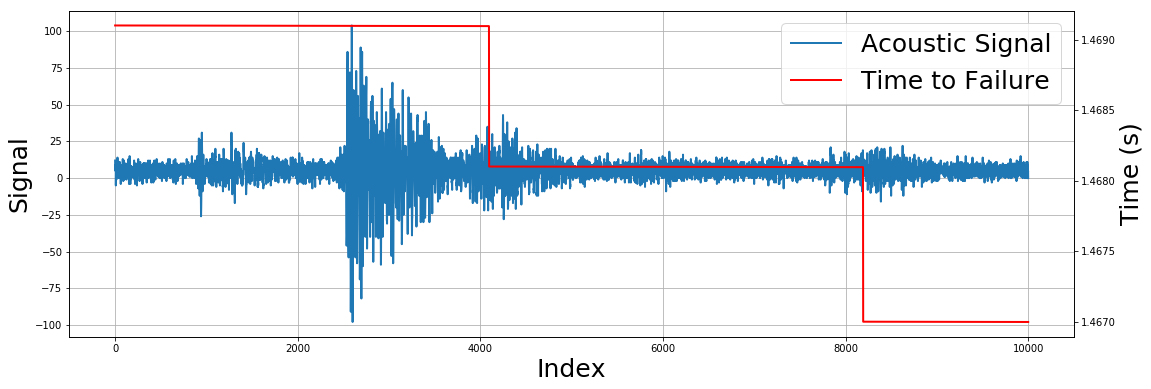

In [5]:
dl.plot_resolution()

In [7]:
dl.resolve_data()

Using mean/std


153638it [09:06, 281.18it/s]


Done! Resolved data saved at D:/Jobs/Incubit/processed_train.csv


In [ ]:
dl.plot_data_sample()

In [ ]:
dl.data_summary()

In [ ]:


naive_features = ['max','min', 'max-min-diff','max-mean-diff', 'mean-change-abs',
                  'std-first-10','std-last-10', 'mean-first-10', 'mean-last-10', 'max-first-10', 
                  'max-last-10','min-first-10', 'min-last-10']
stat_features = ['mean','std','kurt','skew']
freq_features=['mean-abs-DCT', 'max-abs-DCT', 'min-abs-DCT', 'q-DCT-0.05','q-DCT-0.95', 'q-DCT-0.25','q-DCT-0.75']
norm_features = ['max-abs', 'min-abs','norm-2','norm-3']
features = naive_features + stat_features + freq_features + norm_features + ['time_to_failure']

In [ ]:
import scipy.stats as stat
from scipy.fftpack import dct

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]
print(dl.shape())

windowsize = 36
dl.load_data(chunksize = windowsize)
segments = int(np.floor(dl.shape()[0] / windowsize))
X_feat = pd.DataFrame(dtype=np.float64,
                       columns=features)
# y_feat = pd.DataFrame(dtype=np.float64,
#                        columns=)
data_iterator = dl.get_iterator()

for segment , chunk in tqdm(enumerate(data_iterator)):
    x = chunk['acoustic_data'].values
    y = chunk['time_to_failure'].values[-1]
    
    X_feat.loc[segment, 'time_to_failure'] = y
    
    X_feat.loc[segment, 'mean'] = x.mean()
    X_feat.loc[segment, 'std'] = x.std()
    X_feat.loc[segment, 'kurt'] = stat.kurtosis(x)
    X_feat.loc[segment, 'skew'] = stat.skew(x)
    #X_train.loc[segment, 'autocorr'] = autocorr(x)
    
    X_feat.loc[segment, 'max'] = x.max()
    X_feat.loc[segment, 'min'] = x.min()
    X_feat.loc[segment, 'max-min-diff'] = x.max() - np.abs(x.min())
    X_feat.loc[segment, 'max-mean-diff'] = x.max() - x.mean()
    X_feat.loc[segment, 'mean-change-abs'] = np.mean(np.abs(np.diff(x)))    
    X_feat.loc[segment, 'std-first-10'] = x[:10].std()
    X_feat.loc[segment, 'std-last-10'] = x[-10:].std()
    X_feat.loc[segment, 'mean-first-10'] = x[:10].mean()
    X_feat.loc[segment, 'mean-last-10'] = x[-10:].mean()
    X_feat.loc[segment, 'max-first-10'] = x[:10].max()
    X_feat.loc[segment, 'max-last-10'] = x[-10:].max()
    X_feat.loc[segment, 'min-first-10'] = x[:10].min()
    X_feat.loc[segment, 'min-last-10'] = x[-10:].min()
    
    a_dct = np.abs(dct(x))
    X_feat.loc[segment, 'mean-abs-DCT'] = a_dct.mean()
    X_feat.loc[segment, 'max-abs-DCT'] = a_dct.max()
    X_feat.loc[segment, 'min-abs-DCT'] = a_dct.min()    
    X_feat.loc[segment, 'q-DCT-0.05'] = np.quantile(a_dct,0.05)
    X_feat.loc[segment, 'q-DCT-0.95'] = np.quantile(a_dct,0.95)
    X_feat.loc[segment, 'q-DCT-0.25'] = np.quantile(a_dct,0.25)
    X_feat.loc[segment, 'q-DCT-0.75'] = np.quantile(a_dct,0.75)
    
    X_feat.loc[segment, 'max-abs'] = np.abs(x).max()
    X_feat.loc[segment, 'min-abs'] = np.abs(x).min()
    X_feat.loc[segment, 'norm-2'] = np.linalg.norm(x,2)
    X_feat.loc[segment, 'norm-3'] = np.linalg.norm(x,4)


In [ ]:
X_feat.to_csv(DATA_PATH + "x_features.csv", index=False)
#y_feat.to_csv(DATA_PATH + "y_features.csv", index=False)

In [ ]:
X_feat, y_feat = X_feat.values[:,:-1], X_feat.values[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_val, y_train, y_val = train_test_split(X_feat, y_feat, test_size = 0.2, random_state=1210)

In [ ]:
from lightgbm import LGBMRegressor
params = {'num_leaves': 54,'min_data_in_leaf': 79,'objective': 'huber',
         'max_depth': -1, 'learning_rate': 0.01, "boosting": "gbdt",
         # "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,"bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,"metric": 'mae',
         "verbosity": -1,'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501}

In [ ]:
lgbm = LGBMRegressor(nthread=8,n_estimators=10000,
            learning_rate=0.01,num_leaves=128,
            colsample_bytree=0.9497036,subsample=0.8715623,
            max_depth=12,reg_alpha=0.04,
            reg_lambda=0.073,min_child_weight=40,silent=-1,verbose=-1,)

In [ ]:
lgbm.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred_lgbm = lgbm.predict(X_val)
mean_absolute_error(y_val,pred_lgbm)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [ ]:
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
         random_state=0).fit(X_train, y_train)

In [ ]:
gpr.score(X_train, y_train) 

In [ ]:
#from models import NeuralNet
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

DATA_PATH = "D:/Jobs/Incubit/"

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, p):
        super(NeuralNet, self).__init__()
        self.hidden_1 = nn.Linear(n_feature, 220)
        self.bn1 = nn.BatchNorm1d(220)
        
        self.hidden_2 = nn.Linear(220, 140)
        self.bn2 = nn.BatchNorm1d(140)
        
        self.hidden_3 = nn.Linear(140, 10)
        self.bn3 = nn.BatchNorm1d(10)
        
        #self.hidden_4 = nn.Linear(n_hidden, 40)
        
        self.predict = nn.Linear(10, n_output)
        self.dropout = nn.Dropout(p)
        

    def forward(self, x):
        x = F.tanh(self.dropout(self.bn1(self.hidden_1(x))))
        x = F.tanh(self.bn2(self.hidden_2(x)))
        x = F.relu(self.bn3(self.hidden_3(x)))
        #x = F.relu(self.hidden_4(x))
        x = self.predict(x)
        return x

In [ ]:
net = NeuralNet(n_feature=28, n_hidden=400, n_output=1, p = 0.7)
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.L1Loss()

In [ ]:
batchsize = 30
train_iter = pd.read_csv(DATA_PATH+"x_features.csv")

In [ ]:
from livelossplot import PlotLosses
liveloss = PlotLosses()

N_epoch = 200
net.train()
for epoch in range(N_epoch):
    logs = {}

    running_loss = 0.0

    for i in range(train_iter.shape[0]//batchsize):
        data = train_iter.sample(n=batchsize)
        x = torch.from_numpy(data.values[:,:-1]).type('torch.FloatTensor')
        y = torch.from_numpy(data.values[:,-1]).type('torch.FloatTensor')
        prediction = net(x)     # input x and predict based on x
        #print(y)
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        #print(torch.sum(prediction))

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        running_loss = loss.detach()

    epoch_loss = running_loss

    prefix = ''

    logs[prefix + 'log loss'] = epoch_loss.item()

    liveloss.update(logs)
    liveloss.draw()
#     if i % 100 == 0:
#             print("[{:03d}/{:03d}] [Batch_ID: {:03d}] Loss : {:.3f}".format(epoch,N_epoch, i, loss))

In [ ]:
#from models import NeuralNet
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

DATA_PATH = "D:/Jobs/Incubit/"

In [ ]:
df = pd.read_csv(DATA_PATH + "processed_train.csv")
df.shape

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))

        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

In [ ]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_val).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y_val).type(torch.Tensor).view(-1)

X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])

model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()

    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()